<a href="https://colab.research.google.com/github/MarcoC1796/recommender-systems-thesis/blob/main/LatentFactorWithMovieDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys, importlib

user = "MarcoC1796"
repo = "recommender-systems-thesis"
src_dir = "src"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}"
if not path in sys.path:
    sys.path.append(path)

Cloning into 'recommender-systems-thesis'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 185 (delta 50), reused 51 (delta 30), pack-reused 110
Receiving objects: 100% (185/185), 97.12 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Updating files: 100% (24/24), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.LatentFactorsCollabortiveFiltering import LatentFactorsCollaborativeFiltering

plt.style.use("ggplot")

In [ ]:
path = "/content/drive/MyDrive/Thesis/Data/"
path += "ml-1m/ratings.dat"

rnames = ["user_id", "movie_id", "rating", "timestamp"]
movies = pd.read_table(path, sep="::", header=None, names=rnames, engine="python")
movies = movies.drop('timestamp', axis=1)


movies_im = pd.pivot_table(movies, values="rating", index="user_id", columns="movie_id")
movies_im.reset_index(drop=True, inplace=True)
movies_im.columns = range(movies_im.shape[1])
movies_im.rename_axis("user_id", axis="index", inplace=True)
movies_im.rename_axis("item_id", axis="columns", inplace=True)

stacked_series = movies_im.stack().dropna()
transformed_df = stacked_series.reset_index()
transformed_df.columns = ['user_id', 'item_id', 'rating']

R = movies_im.to_numpy()
print(f"R has {round((np.count_nonzero(~np.isnan(R))/R.size)*100, 2)}% of full entries")

movies_array = transformed_df[['user_id', 'item_id', 'rating']].values

train_val_set, test_set = train_test_split(movies_array, test_size=0.2, random_state=42)
print(f"Shape of training set: {train_val_set.shape}")
print(f"Shape of test set: {test_set.shape}")

R has 4.47% of full entries
Shape of training set: (800167, 3)
Shape of test set: (200042, 3)


In [ ]:
import numpy as np
from tqdm.auto import trange
from src.aux_functions import standardize_interactions


class LatentFactorsCollaborativeFiltering:
    def __init__(
        self,
        num_users,
        num_items,
        num_factors=10,
        include_biases=True,
        standardize=True,
    ):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.include_biases = include_biases
        self.user_biases = None
        self.item_biases = None
        self.user_embeddings = None
        self.item_embeddings = None
        self.standardize = standardize
        self.mean_train = None
        self.std_train = None

    def fit(
        self,
        train_interactions,
        validation_interactions=None,
        num_factors=None,
        reg_strength=0,
        epochs=10,
        batch_size=128,
        learning_rate=0.01,
        tolerance=None,
    ):
        if num_factors is not None:
            self.num_factors = num_factors

        if self.standardize:
            train_interactions, mean_train, std_train = standardize_interactions(
                train_interactions
            )
            self.mean_train = mean_train
            self.std_train = std_train
        else:
            _, mean_train, std_train = standardize_interactions(train_interactions)
            self.mean_train = mean_train
            self.std_train = std_train

        self.initililize_embeddings()

        train_errors = []
        validation_errors = []

        pbar_outer = trange(epochs, desc="RMSE: None | Progress: ", leave=False)

        for epoch in pbar_outer:
            np.random.shuffle(train_interactions)

            train_error = 0.0
            validation_error = 0.0

            num_batches = int(np.ceil(len(train_interactions) / batch_size))

            pbar_inner = trange(
                num_batches, desc=f"Epoch {epoch+1}/{epochs}", leave=False
            )

            for batch_idx in pbar_inner:
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size
                batch_interactions = train_interactions[start_idx:end_idx]
                users, items, ratings = np.split(batch_interactions, 3, axis=1)
                users = users.flatten().astype(int)
                items = items.flatten().astype(int)
                ratings = ratings.flatten()
                errors = self.update_params(
                    users, items, ratings, learning_rate, reg_strength
                )
                train_error += np.sum(errors**2)

            train_errors.append(np.sqrt(train_error / len(train_interactions)))

            if validation_interactions is not None:
                validation_error = self.evaluate_RMSE(validation_interactions)
                validation_errors.append(validation_error)

            if tolerance is not None and epoch > 0:
                absolute_improvement = train_errors[-2] - train_errors[-1]
                if absolute_improvement < 0:
                    pbar_outer.set_description(
                        f"Early Stopping at Epoch {epoch+1} due to failure to improve RMSE | RMSE = {train_errors[-1]:.2e} | Progress"
                    )
                    break

                if absolute_improvement / train_errors[-2] < tolerance:
                    pbar_outer.set_description(
                        f"Early Stopping at Epoch {epoch+1} due to tolerance reached | RMSE = {train_errors[-1]:.2e}  | Progress"
                    )
                    break

            pbar_outer.set_description(f"RMSE: {train_errors[-1]:.2e} | Progress")

        pbar_outer.close()
        return train_errors, validation_errors

    def predict(self, user, item):
        user_embedding = self.user_embeddings[user, :]
        item_embedding = self.item_embeddings[item, :]
        return np.dot(user_embedding, item_embedding)

    def predict_batch(self, users, items):
        user_embeddings_batch = self.user_embeddings[users, :]
        item_embeddings_batch = self.item_embeddings[items, :]
        return np.sum(user_embeddings_batch * item_embeddings_batch, axis=1)

    def recommend_items(self, user, top_k=5):
        user_embedding = self.user_embeddings[user, :]
        scores = np.dot(self.item_embeddings, user_embedding)
        top_item_indices = np.argsort(scores)[::-1][:top_k]
        return top_item_indices

    def update_params(self, users, items, ratings, learning_rate, reg_strength):
        errors = ratings - self.predict_batch(users, items)
        user_gradients = errors[:, np.newaxis] * self.item_embeddings[items, :]
        item_gradients = errors[:, np.newaxis] * self.user_embeddings[users, :]
        if reg_strength > 0:
            user_gradients -= reg_strength * self.user_embeddings[users, :]
            item_gradients -= reg_strength * self.item_embeddings[items, :]
        self.user_embeddings[users, :] += learning_rate * user_gradients
        self.item_embeddings[items, :] += learning_rate * item_gradients
        if self.include_biases:
            self.user_embeddings[:, -1] = 1
            self.item_embeddings[:, -2] = 1
        return errors

    def evaluate_RMSE(self, test_interactions):
        test_users, test_items, test_ratings = np.split(test_interactions, 3, axis=1)
        test_users = test_users.flatten().astype(int)
        test_items = test_items.flatten().astype(int)
        test_ratings = test_ratings.flatten()
        test_predictions = self.predict_batch(test_users, test_items)
        if self.standardize:
            test_predictions = test_predictions * self.std_train + self.mean_train
        errors = test_ratings - test_predictions
        test_rmse = np.sqrt(np.mean(errors**2))
        return test_rmse

    def initililize_embeddings(self):
        num_cols_embeddings = (
            self.num_factors + 2 if self.include_biases else self.num_factors
        )

        loc = 0 if self.standardize else self.mean_train
        scale = 1 if self.standardize else self.std_train

        self.user_embeddings = np.random.default_rng().normal(
            loc=loc, scale=scale, size=(self.num_users, num_cols_embeddings)
        )
        self.item_embeddings = np.random.default_rng().normal(
            loc=loc, scale=scale, size=(self.num_items, num_cols_embeddings)
        )

        if self.include_biases:
            self.user_embeddings[:, -1] = 1
            self.item_embeddings[:, -2] = 1

In [ ]:
num_factors_list = [0, 100]
train_errors_result = []
val_errors_result = []
train_errors_result_bias = []
val_errors_result_bias = []
models = []
models_bias = []

pbar = tqdm(num_factors_list)
for num_factors in pbar:
  pbar.set_description(f"Current Factors: {num_factors} | Progress")
  #model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1], include_biases=False)
  #train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=32, learning_rate=1e-2)
  #train_errors_result.append(train_errors)
  #val_errors_result.append(val_errors)
  #models.append(model)
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  reg = 0
  if num_factors ==100:
    reg = 0.1
  train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=15, batch_size=128, learning_rate=1e-2,reg_strength=reg)
  train_errors_result_bias.append(train_errors)
  val_errors_result_bias.append(val_errors)
  models_bias.append(model)

  0%|          | 0/2 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/6252 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/6252 [00:00<?, ?it/s]

In [ ]:
num_factors_list = np.logspace(base=10,start=-2,stop=-1,num=5)
train_errors_result = []
val_errors_result = []
train_errors_result_bias = []
val_errors_result_bias = []
models = []
models_bias = []

pbar = tqdm(num_factors_list)
for num_factors in pbar:
  pbar.set_description(f"Current Factors: {num_factors} | Progress")
  #model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1], include_biases=False)
  #train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=32, learning_rate=1e-2)
  #train_errors_result.append(train_errors)
  #val_errors_result.append(val_errors)
  #models.append(model)
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=100,validation_interactions=test_set, epochs=8, batch_size=128, learning_rate=1e-2,reg_strength=num_factors)
  train_errors_result_bias.append(train_errors)
  val_errors_result_bias.append(val_errors)
  models_bias.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 2/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 3/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 4/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 5/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 6/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 7/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 8/8:   0%|          | 0/6252 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 2/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 3/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 4/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 5/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 6/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 7/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 8/8:   0%|          | 0/6252 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 2/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 3/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 4/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 5/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 6/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 7/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 8/8:   0%|          | 0/6252 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 2/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 3/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 4/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 5/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 6/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 7/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 8/8:   0%|          | 0/6252 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 2/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 3/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 4/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 5/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 6/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 7/8:   0%|          | 0/6252 [00:00<?, ?it/s]

Epoch 8/8:   0%|          | 0/6252 [00:00<?, ?it/s]

In [ ]:
models[-1].item_embeddings[:,-5:]

array([[-0.05516042,  0.11616236,  0.01403577,  1.        ,  0.60461007],
       [-0.24375441, -0.06373552,  0.21303433,  1.        , -0.30946035],
       [-0.04418251, -0.15285573, -0.06219128,  1.        , -0.36767544],
       ...,
       [-1.55025018,  0.2622596 , -0.29681872,  1.        , -0.04746847],
       [-0.19713933, -0.20620868, -1.13795423,  1.        ,  0.13614419],
       [ 0.00397855,  0.03879639, -0.21268627,  1.        ,  0.21850342]])

In [ ]:
np.mean((models[-1].user_embeddings @ models[-1].item_embeddings.T))

-0.17128878347169735

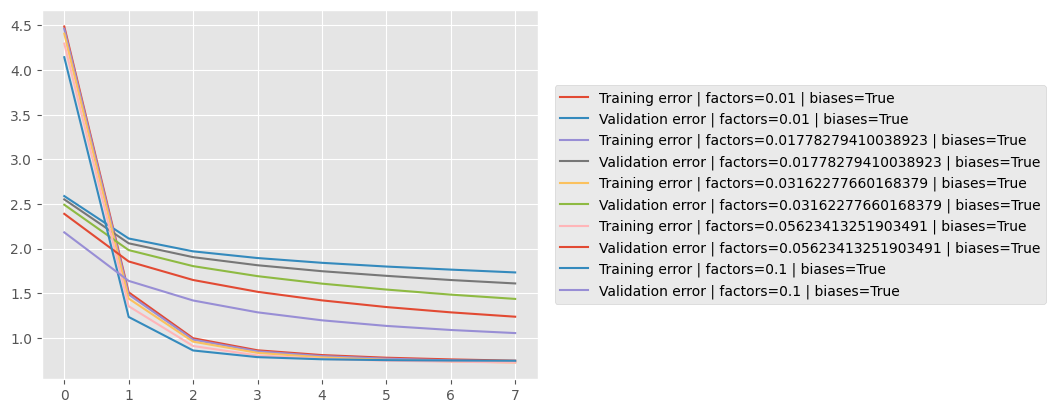

In [ ]:
# Uncomment the following line to adjust the figure size if needed
# plt.figure(figsize=(8, 6))
biases = True
for num_factors, train_errors, val_errors in zip(num_factors_list, train_errors_result_bias, val_errors_result_bias):
    list1 = train_errors
    list2 = val_errors
    # Plotting the lists
    plt.plot(list1[-150:], label=f'Training error | factors={num_factors} | biases={biases}')
    plt.plot(list2[-150:], label=f'Validation error | factors={num_factors} | biases={biases}')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.show()

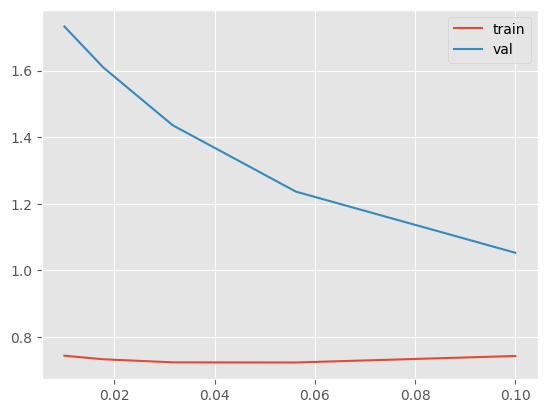

0.1


In [ ]:
i = 1
min_train_errors = [min(val_errors) for val_errors in train_errors_result_bias]
min_val_errors= [min(val_errors) for val_errors in val_errors_result_bias]
plt.plot(num_factors_list, min_train_errors, label="train")
plt.plot(num_factors_list, min_val_errors, label = "val")
plt.legend()
plt.show()
print(num_factors_list[np.argmin(min_val_errors)])

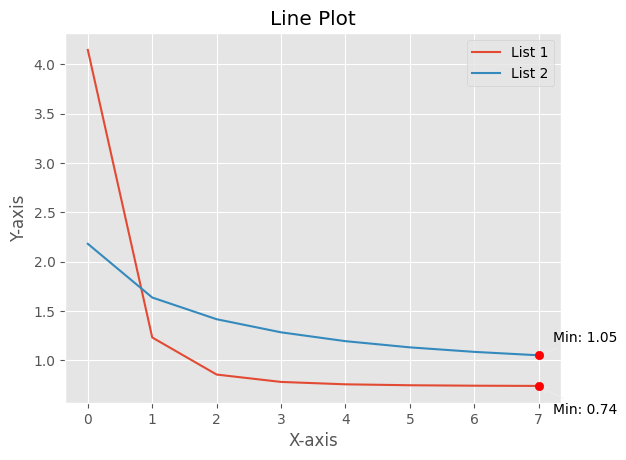

In [ ]:
list1 = train_errors_result_bias[-1]
list2= val_errors_result_bias[-1]
# Plotting the lists
plt.plot(list1, label='List 1')
plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
(models[1].user_embeddings @ models[1].item_embeddings.T)[~np.isnan(R)].max()

18.964789996575757

In [ ]:
models[1].item_embeddings[:,2].max()

1.5517313121105702

In [ ]:
from src.aux_functions import standardize_interactions


class LatentFactorsCollaborativeFiltering2:
    def __init__(self, num_users, num_items, standardize=True):
        self.num_users = num_users
        self.num_items = num_items
        self.user_embeddings = None
        self.item_embeddings = None
        self.standardize = standardize
        self.mean_train = None
        self.std_train = None

    def fit(
        self,
        train_interactions,
        validation_interactions=None,
        num_factors=10,
        epochs=10,
        batch_size=128,
        learning_rate=0.01,
    ):
        if self.standardize:
            train_interactions, mean_train, std_train = standardize_interactions(
                train_interactions
            )
            self.mean_train = mean_train
            self.std_train = std_train

        self.user_embeddings = np.random.normal(
            loc=0, scale=1, size=(self.num_users, num_factors)
        )
        self.item_embeddings = np.random.normal(
            loc=0, scale=1, size=(self.num_items, num_factors)
        )

        train_errors = []
        validation_errors = []

        pbar_outer = trange(epochs, desc="Current Error: None | Training Progress: ")

        for epoch in pbar_outer:
            np.random.shuffle(train_interactions)
            train_error = 0.0
            validation_error = 0.0
            num_batches = len(train_interactions) // batch_size
            pbar_inner = trange(
                num_batches, desc=f"Epoch {epoch+1}/{epochs}", leave=False
            )

            for batch_idx in pbar_inner:
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size
                batch_interactions = train_interactions[start_idx:end_idx]
                users, items, ratings = np.split(batch_interactions, 3, axis=1)
                users = users.flatten().astype(int)
                items = items.flatten().astype(int)
                ratings = ratings.flatten()
                errors = self.update_params(users, items, ratings, learning_rate)
                train_error += np.sum(errors**2)

            train_errors.append(np.sqrt(train_error / len(train_interactions)))
            if validation_interactions is not None:
                validation_error = self.evaluateRMSE(validation_interactions)
                validation_errors.append(validation_error)
            pbar_outer.set_description(
                f"Current Error: {train_errors[-1]:.2e} | Traning Progress"
            )

        return train_errors, validation_errors

    def predict(self, user, item):
        user_embedding = self.user_embeddings[user, :]
        item_embedding = self.item_embeddings[item, :]
        return np.dot(user_embedding, item_embedding)

    def predict_batch(self, users, items):
        user_embeddings_batch = self.user_embeddings[users, :]
        item_embeddings_batch = self.item_embeddings[items, :]
        return np.sum(user_embeddings_batch * item_embeddings_batch, axis=1)

    def recommend_items(self, user, top_k=5):
        user_embedding = self.user_embeddings[user, :]
        scores = np.dot(self.item_embeddings, user_embedding)
        top_item_indices = np.argsort(scores)[::-1][:top_k]
        return top_item_indices

    def update_params(self, users, items, ratings, learning_rate):
        errors = ratings - self.predict_batch(users, items)
        user_gradients = errors[:, np.newaxis] * self.item_embeddings[items, :]
        item_gradients = errors[:, np.newaxis] * self.user_embeddings[users, :]
        self.user_embeddings[users, :] += learning_rate * user_gradients
        self.item_embeddings[items, :] += learning_rate * item_gradients
        return errors

    def evaluateRMSE(self, test_interactions):
        test_users, test_items, test_ratings = np.split(test_interactions, 3, axis=1)
        test_users = test_users.flatten().astype(int)
        test_items = test_items.flatten().astype(int)
        test_ratings = test_ratings.flatten()
        test_predictions = self.predict_batch(test_users, test_items)
        if self.standardize:
            test_predictions = test_predictions * self.std_train + self.mean_train
        errors = test_ratings - test_predictions
        test_rmse = np.sqrt(np.mean(errors**2))
        return test_rmse

In [ ]:
model = LatentFactorsCollaborativeFiltering2(R.shape[0], R.shape[1])
train_errors_100, val_errors_100 = model.fit(train_interactions=train_val_set, num_factors=1,validation_interactions=test_set, epochs=100, batch_size=128, learning_rate=1e-3)

Current Error: None | Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/6251 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/6251 [00:00<?, ?it/s]

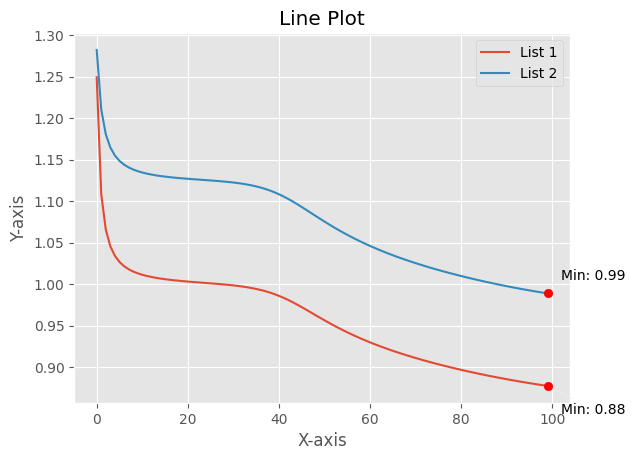

In [ ]:
list1 = train_errors_100
list2 = val_errors_100

# Plotting the lists
plt.plot(list1, label='List 1')
plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
from src.aux_functions import standardize_interactions
import inspect
lines = inspect.getsource(standardize_interactions)
print(lines)

def standardize_interactions(
    interactions, mean_interactions=None, std_interactions=None
):
    if mean_interactions is None:
        mean_interactions = interactions[:, 2].mean()
    if std_interactions is None:
        std_interactions = interactions[:, 2].std()
    interactions_standardized = deepcopy(interactions)
    interactions_standardized[:, 2] = (
        interactions_standardized[:, 2] - mean_interactions
    ) / std_interactions
    return interactions_standardized, mean_interactions, std_interactions

